### Implementation of Residual Attention Network for Image Classification Paper
- Here's my attempt on implementing the paper, **Residual Attention Network for Image Classification Paper** [Link](https://arxiv.org/abs/1704.06904)
- Though, I've written an implementation for this architecture.


In [1]:
%config Completer.use_jedi = False

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob


In [3]:
from PIL import Image
from random import shuffle

In [4]:
import tensorflow_datasets as tfds

In [5]:
import magic

In [6]:
from download_cats_dogs import CatDogDataset

In [7]:
import pathlib

In [8]:
def make_dir(target_dir):
    
    if not os.path.isdir(target_dir):
        print('Making Directory ', target_dir)
        os.mkdir(target_dir)
    else:
        print('Directory already exists')

In [9]:
def remove_non_jpg(target_dir):
    
    filepaths = glob.glob(target_dir + '/**/*', recursive=True)
    count = 0
    total = len(filepaths)
    
    for idx, fp in enumerate(filepaths, start=1):
        print(f'[{idx}/{total}] Processing files.', end='\r')
        if os.path.isfile(fp):
            if magic.from_file(fp).split(' ')[0] != 'JPEG':
                print('Removing file ', fp, end='\r')
                os.remove(fp)
                count += 1
    
    print('')
    print(f'Removed {count} non-jpg images')

In [10]:
# !kaggle datasets download -d jehanbhathena/weather-dataset -p ../dataset/ --unzip

In [11]:
# data_dir = '../dataset/dataset/'

In [12]:
data_dir_str = '../dataset/dataset/'

In [13]:
remove_non_jpg(data_dir_str)

[6702/6702] Processing files.
Removed 0 non-jpg images


In [14]:

# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir_str)


In [15]:
os.listdir(data_dir_str)

['dew',
 'lightning',
 'rainbow',
 'snow',
 'fogsmog',
 'rain',
 'hail',
 'frost',
 'glaze',
 'sandstorm',
 'rime']

In [16]:
import PIL

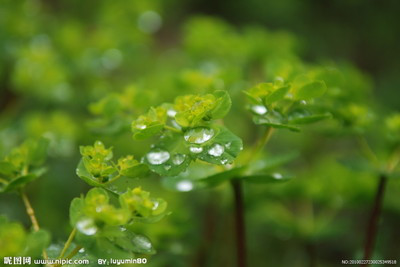

In [17]:
sample_cat = list(data_dir.glob('dew/*'))
PIL.Image.open(str(sample_cat[5]))


In [18]:
data_dir

PosixPath('../dataset/dataset')

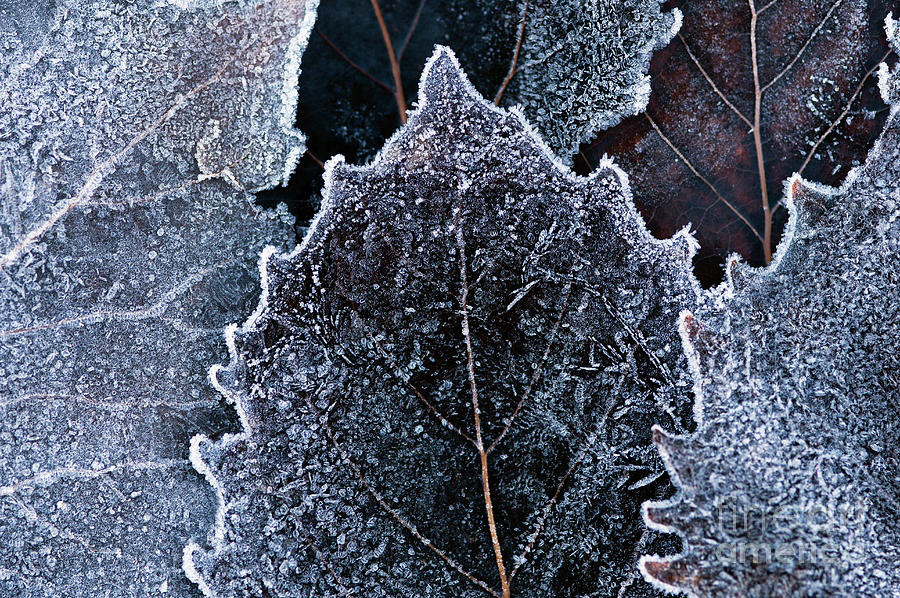

In [19]:
sample_cat = list(data_dir.glob('frost/*'))
PIL.Image.open(str(sample_cat[6]))

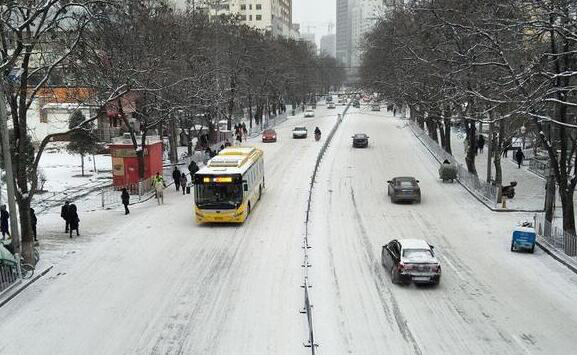

In [20]:
sample_cat = list(data_dir.glob('snow/*'))
PIL.Image.open(str(sample_cat[0]))

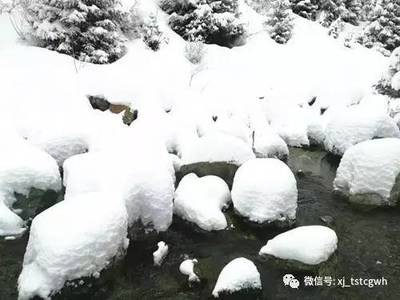

In [21]:
PIL.Image.open(str(sample_cat[2]))


In [22]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [24]:
import numpy as np

AUTO = tf.data.AUTOTUNE
batch_size = 32
img_height = 224
img_width = 224

SEED_ONE = np.random.randint(low=500, high=1000)


In [25]:
# tr_augmentation = tf.keras.Sequential([
#   keras.layers.Lambda(lambda data_one, data_two)
#   keras.layers.RandomFlip("horizontal"),
#   keras.layers.RandomRotation(0.2),
#   keras.layers.Rescaling(1./255)
# ])

# val_augmentation = tf.keras.Sequential([
#   keras.layers.Rescaling(1./255)
# ])



In [26]:


tr_ds_init = keras.utils.image_dataset_from_directory(
  data_dir_str,
  validation_split=0.1,
  subset="training",
  seed=SEED_ONE,
  image_size=(img_height, img_width),
  batch_size=1, label_mode='categorical')


val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_str,
  validation_split=0.1,
  subset="validation",
  seed=SEED_ONE,
  image_size=(img_height, img_width),
  batch_size=batch_size, label_mode='categorical')

# tr_ds = tr_ds.map(lambda x, y: (tr_augmentation(x), y), num_parallel_calls=AUTOTUNE).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.map(lambda x, y: (val_augmentation(x), y), num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)


tr_ds_one = tr_ds_init.map(lambda x,y: (tf.squeeze(x, axis=0),
                                        tf.squeeze(y,axis=0))).shuffle(batch_size * 100).batch(batch_size, drop_remainder=True)
tr_ds_two = tr_ds_init.map(lambda x,y: (tf.squeeze(x, axis=0),
                                        tf.squeeze(y,axis=0))).shuffle(batch_size * 100).batch(batch_size, drop_remainder=True)

Found 6691 files belonging to 11 classes.
Using 6022 files for training.


2021-12-13 14:32:56.159531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-13 14:32:56.215916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-13 14:32:56.216234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-13 14:32:56.218681: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Found 6691 files belonging to 11 classes.
Using 669 files for validation.


In [27]:
# X,y = next(iter(tr_ds_one))
# print(X.shape)
# y.shape

#### Source:

Sayak Paul's Tutorial on MixUp Augmentation: https://keras.io/examples/vision/mixup/

In [28]:
tr_ds = tf.data.Dataset.zip((tr_ds_one, tr_ds_two))

In [29]:

class MixingAugment(keras.layers.Layer):
    
    def __init__(self, *args, **kwargs):
        super(MixingAugment, self).__init__(*args, **kwargs)
        
        self.post_mix = keras.Sequential([
              keras.layers.RandomFlip("horizontal"),
              keras.layers.RandomRotation(0.2),
              keras.layers.Rescaling(1./255)
        ])
        
#         self.alpha = alpha
    
#     @tf.function
    def sample_beta_distribution(self, size, concentration_0=0.2, concentration_1=0.2):
        gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
        gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
        return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

#     @tf.function
    def mix_up(self, ds_one, ds_two):
        # Unpack two datasets
        images_one, labels_one = ds_one
        images_two, labels_two = ds_two
        
        batch_size = tf.shape(images_one)[0]
        
        alpha = tf.random.uniform([1,], minval=0, maxval=0.5)[0]

        # Sample lambda and reshape it to do the mixup
        l = self.sample_beta_distribution(batch_size, alpha, alpha)
        x_l = tf.reshape(l, (batch_size, 1, 1, 1))
        y_l = tf.reshape(l, (batch_size, 1))

        # Perform mixup on both images and labels by combining a pair of images/labels
        # (one from each dataset) into one image/label
        images = images_one * x_l + images_two * (1 - x_l)
        labels = labels_one * y_l + labels_two * (1 - y_l)
        return (images, labels)
    

    def call(self, data_one, data_two):
        
        x, y = self.mix_up(data_one, data_two)
        x = self.post_mix(x)
        return x,y
    
    
val_augmentation = tf.keras.Sequential([
  keras.layers.Rescaling(1./255)
])
        

In [30]:
mix_aug = MixingAugment()

In [31]:
# for data_one, data_two in tr_ds:
    
#     print('data_one[0] = ', data_one[0].shape)
#     print('data_one[0] = ', data_one[1].shape)
    
#     print('data_two[0] = ', data_two[0].shape)
#     print('data_two[0] = ', data_two[1].shape)
    
#     X,y = mix_aug(data_one, data_two)
    
#     print('X = ', X.shape)
#     print('X = ', y.shape)

In [32]:
# tr_ds = tr_ds.map(
#     lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=AUTO
# )



tr_ds = tr_ds.map(
    lambda data_one, data_two : mix_aug(data_one, data_two), num_parallel_calls=AUTO
)

val_ds = val_ds.map(
    lambda X,y : (val_augmentation(X),y), num_parallel_calls=AUTO
)

In [33]:
# X,y = next(iter(tr_ds))

2021-12-13 14:33:05.873958: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


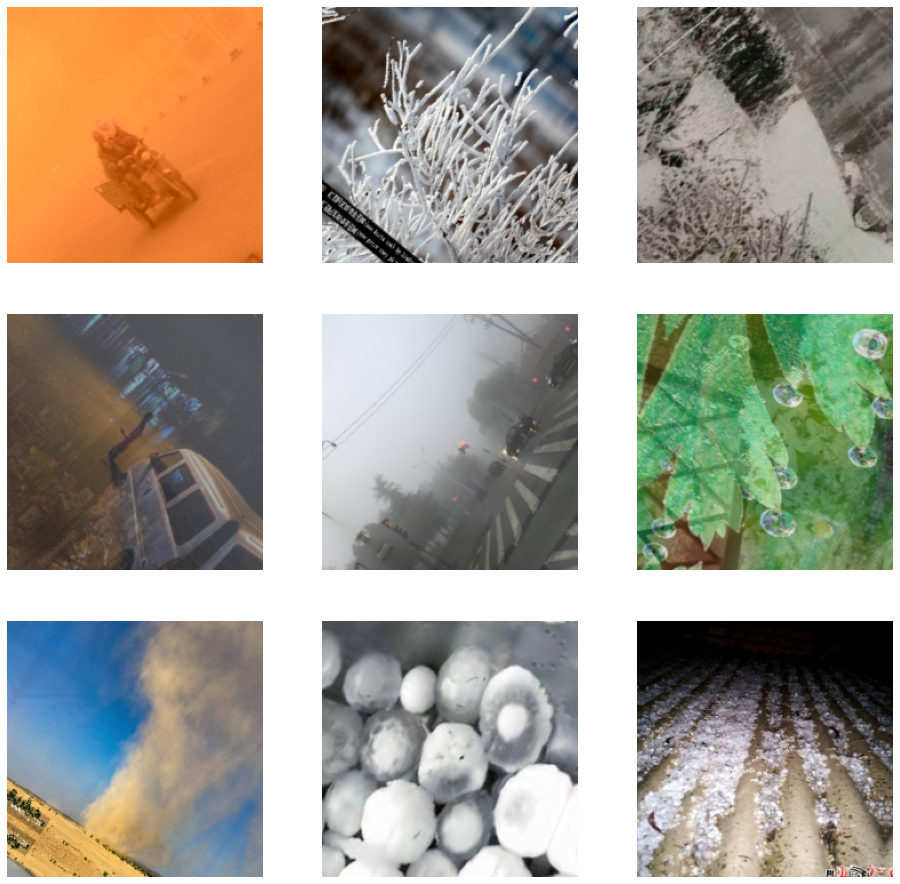

In [34]:
sample_images, sample_labels = next(iter(tr_ds))
plt.figure(figsize=(16, 16))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(image.numpy().squeeze().astype(np.uint8))
    plt.imshow(image.numpy().squeeze())
    plt.axis("off")

In [35]:
def plot_image(image):
    plt.imshow(image)
    plt.axis("off")

In [36]:
class InitialConv(keras.layers.Layer):
    
    def __init__(self, 
                 filters : int, 
                 kernel_size : int, 
                 strides : int,
                 pool_size : int,
                 data_format='channels_last',
                 activation='relu',
                 conv_pad_size=3,
                 pool_pad_size=1,
                 *args, **kwargs):
        
        super(InitialConv, self).__init__(*args, **kwargs)
        
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides

        self.pool_size = pool_size
        self.data_format = data_format
        self.activation = keras.activations.get(activation)
        
        self.conv_pad_size = conv_pad_size
        self.pool_pad_size = pool_pad_size
        
        
    def build(self, input_shape):
        
        conv_pad_shape = (self.conv_pad_size, self.conv_pad_size)
        
        self.zpad_01 = keras.layers.ZeroPadding2D(
            padding=conv_pad_shape,
            data_format=self.data_format,
            input_shape=input_shape)
        
        self.conv = keras.layers.Conv2D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            strides=self.strides,
            padding='valid',
            data_format=self.data_format
        )
        
        self.bnorm = keras.layers.BatchNormalization()
        pool_pad_shape = (self.pool_pad_size, self.pool_pad_size)
        
        self.zpad_02 = keras.layers.ZeroPadding2D(
            padding=pool_pad_shape,
            data_format=self.data_format
        )
        
        self.pool = keras.layers.MaxPool2D(
            pool_size=self.pool_size,
            strides=self.strides, 
            padding='valid'
        )
        
        
    def call(self, x):
        
        x = self.zpad_01(x)
        x = self.conv(x)
        x = self.bnorm(x)
        x = self.activation(x)
        x = self.zpad_02(x)
        x = self.pool(x)
        
        return x
            

In [37]:
class BatchNormConv2D(keras.layers.Layer):
    
    def __init__(self, 
                 filters,
                 kernel_size=1,
                 strides=1,
                 padding_size=0,
                 activation='relu',
                 data_format='channels_last',
                 *args, **kwargs):
        
        super(BatchNormConv2D, self).__init__(*args, **kwargs)
        self.activation = keras.activations.get(activation)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.data_format=data_format
        
        self.padding_size = padding_size
                            

    def build(self, input_shape):
        
        self.bnorm = keras.layers.BatchNormalization(
            input_shape=input_shape)
        

        padding_shape = (self.padding_size, self.padding_size)
        
        self.zero_pad = keras.layers.ZeroPadding2D(
            padding=padding_shape,
            data_format=self.data_format
        )
        
        self.conv = keras.layers.Conv2D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            strides=self.strides,
            padding='valid',
            data_format=self.data_format
        )
        
         
    def call(self, x):
        
        x = self.bnorm(x)
        x = self.activation(x)
        x = self.zero_pad(x)
        x = self.conv(x)
        return x




In [38]:
class ResidualBlock(keras.layers.Layer):
    
    def __init__(self, 
                 filters, 
                 strides=1, 
                 data_format='channels_last',
                 *args, **kwargs):
        
        super(ResidualBlock, self).__init__(*args, **kwargs)
        
        self.filters = filters
        
        self.mid_kernel_size = 3
        self.mid_pad_size = 1
        
        self.strides = strides
        self.data_format= data_format
        
    
    def create_projection(self, input_shape):
        return keras.layers.Conv2D(
            filters=self.filters,
            kernel_size=1,
            strides=self.strides,
            data_format=self.data_format
        )
    
        
    def build(self, input_shape):
        
        f1 = self.filters // 4
        f2 = self.filters // 4
        f3 = self.filters 
        
        self.projection = self.create_projection(input_shape=input_shape)
        
        self.bn_conv1 = BatchNormConv2D(filters=f1,
                                        data_format=self.data_format,
                                        input_shape=input_shape)
        
        self.bn_conv2 = BatchNormConv2D(filters=f2, 
                                        kernel_size=self.mid_kernel_size, 
                                        padding_size=self.mid_pad_size,
                                        strides=self.strides,
                                        data_format=self.data_format)
        
        self.bn_conv3 = BatchNormConv2D(filters=f3, 
                                        data_format=self.data_format)
        
        
    def call(self, x):
        
        skip = self.projection(x)
        
        x = self.bn_conv1(x)
        x = self.bn_conv2(x)
        x = self.bn_conv3(x)
        
        return x + skip      
        
            

In [39]:
class ResidualBlocks(keras.models.Model):
    
    def __init__(self, 
                 filters,
                 data_format='channels_last',
                 depth=1, *args, **kwargs):
        
        super(ResidualBlocks, self).__init__(*args, **kwargs)
        
        assert depth > 0, 'trunk_depth must be greater than zero.'
        
        self.data_format = data_format
        self.depth = depth
        self.filters = filters
        
        blocks = self.depth * [
            ResidualBlock(filters=self.filters, 
                          data_format=self.data_format)
        ]
        
        self.main_trunk = keras.Sequential(blocks)


    def call(self, x):
        return self.main_trunk(x)
        
        

In [40]:
class SoftMaskBranch_STG_01(keras.models.Model):
    
    def __init__(self, filters, 
                 num_segments=1,
                 data_format='channels_last', 
                 *args, **kwargs):
        
        super(SoftMaskBranch_STG_01, self).__init__(*args, **kwargs)
                
        self.num_segments = num_segments
        self.data_format = data_format
        self.filters = filters
        
        self.down_sampler = keras.layers.MaxPool2D((3,3), 2, data_format=self.data_format)
        
        self.up_sampler_01 = keras.layers.Resizing(13,13)
        self.up_sampler_02 = keras.layers.Resizing(27,27)
        self.up_sampler_03 = keras.layers.Resizing(56,56)        
        
        self.rb_01 = ResidualBlocks(filters, depth=num_segments, data_format=self.data_format)
        self.rb_02 = ResidualBlocks(filters, depth=num_segments, data_format=self.data_format)
        self.rb_03 = ResidualBlocks(filters, depth=2*num_segments, data_format=self.data_format)
        self.rb_04 = ResidualBlocks(filters, depth=num_segments, data_format=self.data_format)
        self.rb_05 = ResidualBlocks(filters, depth=num_segments, data_format=self.data_format)
        
        self.conv_06 = keras.layers.Conv2D(filters, 
                                           kernel_size=1, 
                                           activation='relu', 
                                           data_format=self.data_format)
        
        self.conv_07 = keras.layers.Conv2D(filters, 
                                           kernel_size=1, 
                                           activation='sigmoid', 
                                           data_format=self.data_format)
        
        self.rb_skip_01 = ResidualBlock(filters, data_format=self.data_format)
        self.rb_skip_02 = ResidualBlock(filters, data_format=self.data_format)
        
        
    def call(self, x):
        
#         tf.debugging.assert_equal(x.shape[1], 56, 'Expecting Tensor with Size (56x56).')
        
        # Input (56x56)
        x = self.down_sampler(x)        # downsampled size = (27x27)
        x = self.rb_01(x)
        
        skip_01 = self.rb_skip_01(x)    
        
        print()
        x = self.down_sampler(x)        # downsampled size = (13x13)
        x = self.rb_02(x)
        skip_02 = self.rb_skip_02(x)    
        
        
        x = self.down_sampler(x)        # downsampled size = (6x6)
        x = self.rb_03(x)
                
        
        x = self.up_sampler_01(x)       # upsampled size = (13x13)
        x += skip_02
        x = self.rb_04(x)
        
        x = self.up_sampler_02(x)       # upsampled size = (27x27)
        x += skip_01
        x = self.rb_05(x)
        
        x = self.up_sampler_03(x)       # upsampled size = (27x27)
        
        x = self.conv_06(x)
        x = self.conv_07(x)
        
        return x
        
        
        

In [41]:
class SoftMaskBranch_STG_02(keras.models.Model):
    
    def __init__(self, filters, 
                 num_segments=1,
                 data_format='channels_last', 
                 *args, **kwargs):
        
        super(SoftMaskBranch_STG_02, self).__init__(*args, **kwargs)
                
        self.num_segments = num_segments
        self.data_format = data_format
        self.filters = filters
        
        self.down_sampler = keras.layers.MaxPool2D((3,3), 2, data_format=self.data_format)
        
        self.up_sampler_01 = keras.layers.Resizing(13,13)
        self.up_sampler_02 = keras.layers.Resizing(28,28)
        
        self.rb_01 = ResidualBlocks(filters, depth=num_segments, data_format=self.data_format)
        self.rb_02 = ResidualBlocks(filters, depth=2*num_segments, data_format=self.data_format)
        self.rb_03 = ResidualBlocks(filters, depth=num_segments, data_format=self.data_format)
        
        self.conv_05 = keras.layers.Conv2D(filters, 
                                           kernel_size=1, 
                                           activation='relu',
                                           data_format=self.data_format)
        
        self.conv_06 = keras.layers.Conv2D(filters, 
                                           kernel_size=1, 
                                           activation='sigmoid',
                                           data_format=self.data_format)
        
        self.rb_skip_01 = ResidualBlock(filters, data_format=self.data_format)
        
        
    def call(self, x):
        
        # Input = (28x28)
#         tf.debugging.assert_equal(x.shape[1], 28, 'Expecting Tensor with Size (28x28).')
        
        x = self.down_sampler(x)        # downsampled size = (13x13)
        x = self.rb_01(x)
        skip_01 = self.rb_skip_01(x)    
        
        x = self.down_sampler(x)        # downsampled size = (13x13)
        x = self.rb_02(x)
        
        x = self.up_sampler_01(x)       # upsampled size = (13x13)
        x += skip_01
        x = self.rb_03(x)
        
        x = self.up_sampler_02(x)       # upsampled size = (28x28)
        
        x = self.conv_05(x)
        x = self.conv_06(x)
        
        return x
        
        
        

In [42]:
class SoftMaskBranch_STG_03(keras.models.Model):
    
    def __init__(self, filters, 
                 num_segments=1,
                 data_format='channels_last', 
                 *args, **kwargs):
        
        super(SoftMaskBranch_STG_03, self).__init__(*args, **kwargs)
                
        self.num_segments = num_segments
        self.data_format = data_format
        self.filters = filters
        
        self.down_sampler = keras.layers.MaxPool2D((3,3), 2)
        
        self.up_sampler_01 = keras.layers.Resizing(14,14)
        
        self.rb_01 = ResidualBlocks(filters, depth=num_segments, data_format=self.data_format)
        self.rb_02 = ResidualBlocks(filters, depth=2*num_segments, data_format=self.data_format)
        self.rb_03 = ResidualBlocks(filters, depth=num_segments, data_format=self.data_format)
        
        self.conv_05 = keras.layers.Conv2D(filters, kernel_size=1, 
                                           activation='relu', 
                                           data_format=self.data_format)
        
        self.conv_06 = keras.layers.Conv2D(filters, kernel_size=1, 
                                           activation='sigmoid',
                                           data_format=self.data_format)
        

        
    def call(self, x):
        
#         tf.debugging.assert_equal(x.shape[1], 14, 'Expects Tensor with Size (14x14).')
        
        x = self.down_sampler(x)        # downsampled size = (6x6)

        x = self.rb_01(x)
        x = self.rb_02(x)
        x = self.rb_03(x)

        
        x = self.up_sampler_01(x)       # upsampled size = (13x13)

        x = self.conv_05(x)
        x = self.conv_06(x)

        
        return x

In [43]:
class ResidualAttentionModule(keras.models.Model):
    
    def __init__(self, filters, stage,
                       pre_post_depth=1, 
                       trunk_depth=2,
                       soft_mask_segments=1,
                       *args, **kwargs):
        
        super(ResidualAttentionModule, self).__init__(*args, **kwargs)
        
        
        assert 0 < stage <= 3, 'Stage must be either 1,2,3'
        
        self.filters = filters
        self.stage = stage
        self.pre_post_depth = pre_post_depth
        self.trunk_depth = trunk_depth
        self.soft_mask_segments = soft_mask_segments
        
        
        self.pre_blocks = ResidualBlocks(filters=self.filters,
                                          depth=self.pre_post_depth)
        
        self.trunk_branch = ResidualBlocks(filters=self.filters, 
                                           depth=self.trunk_depth)
        
        self.post_blocks = ResidualBlocks(filters=self.filters,
                                          depth=self.pre_post_depth)
        
        
        if stage == 1:
            self.soft_mask_branch = SoftMaskBranch_STG_01(filters=self.filters,
                                                          num_segments=self.soft_mask_segments)
            
        elif stage == 2:
            self.soft_mask_branch = SoftMaskBranch_STG_02(filters=self.filters,
                                                          num_segments=self.soft_mask_segments)
            
        elif stage == 3:
            self.soft_mask_branch = SoftMaskBranch_STG_03(filters=self.filters,
                                                          num_segments=self.soft_mask_segments)
            
            
    def call(self, x):
        
        x = self.pre_blocks(x)
 
        x_trunk = self.trunk_branch(x)
        x_mask = self.soft_mask_branch(x)
        x_masked = tf.math.multiply(x_trunk, x_mask)
        x = tf.math.add(x_trunk, x_masked)
        x = self.post_blocks(x)
        
        return x
        
        


In [44]:
model_root = '../model'
model_dir = '../model/residual_attention_v8'

make_dir(model_root)
make_dir(model_dir)

Directory already exists
Directory already exists


In [44]:
X,y = next(iter(tr_ds))

In [45]:

# N_CLASSES = 11

# model = keras.Sequential([

#     InitialConv(filters=64, kernel_size=7,strides=2, pool_size=3, input_shape=[224,224,3]),
#     ResidualAttentionModule(filters=256, stage=1),
#     ResidualBlock(filters=512, strides=2),
#     ResidualAttentionModule(filters=512, stage=2),
#     ResidualBlock(filters=1024, strides=2),
#     ResidualAttentionModule(filters=1024, stage=3),
#     ResidualBlock(filters=2048, strides=1),
#     ResidualBlock(filters=2048, strides=1),
#     ResidualBlock(filters=2048, strides=1),
#     ResidualBlock(filters=2048, strides=2),
#     keras.layers.AveragePooling2D((7,7), strides=1),
#     keras.layers.Dropout(0.2),
#     keras.layers.Flatten(),
#     keras.layers.Dense(1000, 'relu'),

#     keras.layers.Dense(N_CLASSES)
# ])

# model(X).shape

In [46]:

N_CLASSES = 11

model = keras.Sequential([

    InitialConv(filters=32, kernel_size=7,strides=2, pool_size=3, input_shape=[224,224,3]),
    ResidualAttentionModule(filters=128, stage=1),
    ResidualBlock(filters=256, strides=2),
    ResidualAttentionModule(filters=256, stage=2),
    ResidualBlock(filters=512, strides=2),
    ResidualAttentionModule(filters=512, stage=3),
    ResidualBlock(filters=1028, strides=1),
    ResidualBlock(filters=1028, strides=1),
    ResidualBlock(filters=1028, strides=2),
    keras.layers.AveragePooling2D((7,7), strides=1),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(100, 'relu'),

    keras.layers.Dense(N_CLASSES, 'softmax')
])

# model(X).shape


In [47]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [48]:
# X,y = next(iter(val_ds))
# y

In [49]:
model_path = os.path.join(model_dir, 'model.h5')
model_cb = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, save_weights_only=True)
es_cb = EarlyStopping(monitor='val_accuracy', patience=10)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4),
              loss='categorical_crossentropy', metrics='accuracy')

num_epochs = 100
history = model.fit(tr_ds, validation_data=val_ds, epochs=num_epochs, callbacks=[model_cb, es_cb])

Epoch 1/100




2021-12-13 14:33:43.278994: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2021-12-13 14:33:44.480540: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-12-13 14:33:44.480922: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-12-13 14:33:44.480943: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2021-12-13 14:33:44.481363: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-12-13 14:33:44.481410: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-12-13 14:33:46.992705: W tensorflow/core/common_runtime/bf

188/188 [==============================] - 70s 225ms/step - loss: 2.0411 - accuracy: 0.4028 - val_loss: 3.8952 - val_accuracy: 0.1674


2021-12-13 14:34:33.579856: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


Epoch 2/100
188/188 [==============================] - 51s 213ms/step - loss: 1.6234 - accuracy: 0.4985 - val_loss: 2.1838 - val_accuracy: 0.3079
Epoch 3/100
188/188 [==============================] - 51s 213ms/step - loss: 1.5554 - accuracy: 0.5070 - val_loss: 1.4653 - val_accuracy: 0.4873
Epoch 4/100
188/188 [==============================] - 51s 215ms/step - loss: 1.4716 - accuracy: 0.5470 - val_loss: 1.3371 - val_accuracy: 0.5277
Epoch 5/100
188/188 [==============================] - 51s 214ms/step - loss: 1.4280 - accuracy: 0.5620 - val_loss: 1.8293 - val_accuracy: 0.4395
Epoch 6/100
188/188 [==============================] - 51s 214ms/step - loss: 1.3956 - accuracy: 0.5883 - val_loss: 1.3554 - val_accuracy: 0.5635
Epoch 7/100
188/188 [==============================] - 51s 215ms/step - loss: 1.3556 - accuracy: 0.5986 - val_loss: 1.3929 - val_accuracy: 0.5396
Epoch 8/100
188/188 [==============================] - 51s 215ms/step - loss: 1.3409 - accuracy: 0.6089 - val_loss: 1.6620 -

In [57]:
hist_data = history.history.copy()

In [62]:
import json

def save_json(hist_data, path):
    
    with open(path,'w') as f:
        f.write(json.dumps(hist_data, indent=4))
        
save_json(hist_data, 'history_data.json')

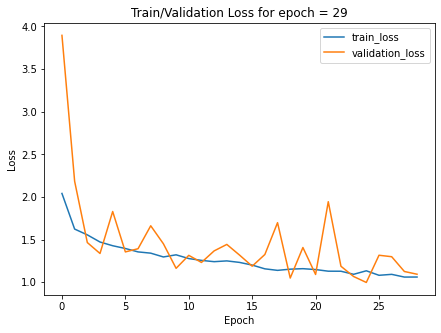

In [74]:
total_epoch = len(hist_data['loss'])
plt.figure(figsize=(7, 5))
plt.plot(hist_data['loss'], label='train_loss')
plt.plot(hist_data['val_loss'], label='validation_loss')
plt.legend()
plt.title(f'Train/Validation Loss for epoch = {total_epoch}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

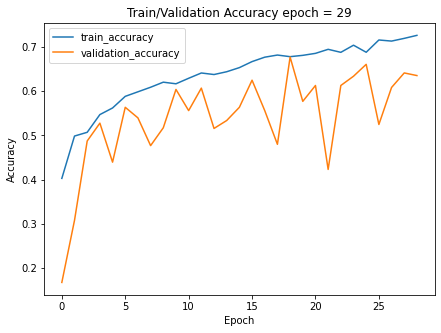

In [75]:
plt.figure(figsize=(7, 5))
plt.plot(hist_data['accuracy'], label='train_accuracy')
plt.plot(hist_data['val_accuracy'], label='validation_accuracy')
plt.legend()
plt.title(f'Train/Validation Accuracy epoch = {total_epoch}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [72]:
print('Best Validation Loss: ',np.min(hist_data['val_loss']))
print('Best Validation Accuracy: ',np.max(hist_data['val_accuracy']))

Best Validation Loss:  0.9973596930503845
Best Validation Accuracy:  0.6771300435066223


In [56]:
make_dir('../dataset/resized_dataset')

![Residual Unit](images/residual_unit.png)

In [12]:
from resnet_50 import building_block, block_layer

![Architecture](images/resnet_attn_architecture.png)

![Parameter Reference](images/layer_parameter_table.png)